In [1]:
# установка необходимых библиотек
!sudo apt-get install libmagickwand-dev
!pip install --no-cache-dir \
    opencv-python-headless==4.6.*\
    rawpy==0.17.* \
    pandas \
    Pillow==7.1.2 \
    scikit-image==0.16.2 \
    scipy==1.5.0 \
    tqdm \
    Wand

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common libblkid-dev libcairo-script-interpreter2 libcairo2-dev
  libdjvulibre-dev libdjvulibre-text libdjvulibre21 libffi-dev
  libgdk-pixbuf2.0-bin libgdk-pixbuf2.0-dev libglib2.0-dev libglib2.0-dev-bin
  libgs9 libgs9-common libidn11 libijs-0.35 libjbig2dec0 liblcms2-dev
  liblqr-1-0 liblqr-1-0-dev liblzo2-2 libmagickcore-6-arch-config
  libmagickcore-6-headers libmagickcore-6.q16-6 libmagickcore-6.q16-6-extra
  libmagickcore-6.q16-dev libmagickwand-6-headers libmagickwand-6.q16-6
  libmagickwand-6.q16-dev libmount-dev libpixman-1-dev librsvg2-dev
  libselinux1-dev libsepol1-dev libwmf-dev libwmf0.2-7 libxcb-r

In [2]:
# скачивание репозитория архивом
!curl -L -o master.zip http://github.com/andreacos/BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation/zipball/master/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10.5M    0 10.5M    0     0  10.1M      0 --:--:--  0:00:01 --:--:-- 26.8M


In [3]:
# Распаковка архива и изменение названия
!unzip master.zip
!rm master.zip
!mv andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209 repo
# !sudo rm -rf folderName

Archive:  master.zip
b4bd209595c1dbd27841c47314a3a1b3af576f7d
   creating: andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209/
  inflating: andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209/README.md  
  inflating: andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209/batch.py  
  inflating: andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209/configuration.py  
  inflating: andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209/datasets.py  
  inflating: andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209/densenet.py  
  inflating: andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209/localization.py  
   creating: andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209/models/
  inflating: andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209/models/model_QF1_55-98_QF2_80-2-term-loss.h5  
  inflating

In [4]:
# необходимые библиотеки
import os
import io
import sys
import glob

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.util import view_as_windows
from PIL import Image

from typing import Any, Dict, List, Optional, Tuple, Union

%matplotlib inline

In [5]:
# Установим путь к репозиторию
sys.path.insert(1, '/content/repo')

In [6]:
# Импорт модулей из репозитория
import localization
import utils
import networks

In [7]:
# Подключаем директорию картинок
from google.colab import drive


drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Необходимые константы
IMAGE_FOLDER_PATH = "/content/drive/MyDrive/Colab Notebooks/ML for IS/images"
BASE_STRIDE = 1
BASE_IMAGE_SHAPE = (200, 200)
MODEL_PATH = "/content/repo/models/model_QF1_60-98_QF2_90-2-term-loss.h5"
QF1_QF2_MAP_PATH = "/content/repo/resources/qf1_qf2_map_90.npy"

QF11 = 95
QF12 = 85
QF2 = 90

In [9]:
qf_map = np.load(QF1_QF2_MAP_PATH, allow_pickle=True)
qf_map.shape

(39, 3)

In [10]:
image_files = glob.glob(IMAGE_FOLDER_PATH + "/**/*.tif", recursive=True)
print("\n".join(image_files))

/content/drive/MyDrive/Colab Notebooks/ML for IS/images/103.tif
/content/drive/MyDrive/Colab Notebooks/ML for IS/images/110.tif
/content/drive/MyDrive/Colab Notebooks/ML for IS/images/108.tif
/content/drive/MyDrive/Colab Notebooks/ML for IS/images/102.tif
/content/drive/MyDrive/Colab Notebooks/ML for IS/images/107.tif
/content/drive/MyDrive/Colab Notebooks/ML for IS/images/101.tif
/content/drive/MyDrive/Colab Notebooks/ML for IS/images/104.tif
/content/drive/MyDrive/Colab Notebooks/ML for IS/images/106.tif
/content/drive/MyDrive/Colab Notebooks/ML for IS/images/109.tif
/content/drive/MyDrive/Colab Notebooks/ML for IS/images/105.tif


(200, 200, 3)

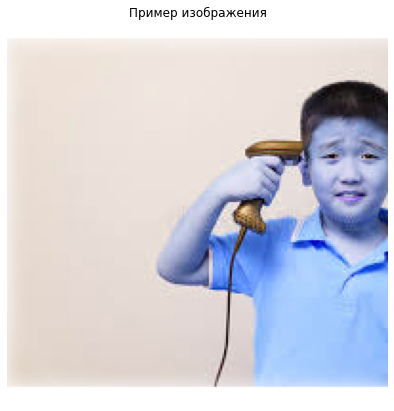

In [11]:
sample_image = cv2.imread(image_files[0])
plt.figure(figsize=(7, 7))
plt.title("Пример изображения")
plt.imshow(sample_image)
_ = plt.axis("off")
sample_image.shape

In [12]:
# Вспомогательные функции

def load_images(
    file_paths: List[str],
    image_shape: Optional[Tuple[int, int]] = None,
) -> np.ndarray:
  """Функция загрузки изображений."""
  image_list = []
  for file_path in tqdm(file_paths):
    image = cv2.imread(file_path)
    if image_shape is not None:
      image = cv2.resize(image, image_shape)
    image_list.append(image)    
  return np.array(image_list)


def jpeg_compress(
    image: np.ndarray,
    qf_value: Union[List[int], int],
  ) -> np.ndarray:
  """Функция JPEG-сжатия."""
  jpeg_image = image
  qf_value_ = qf_value
  if type(qf_value_) == int:
    qf_value_ = [qf_value_]
  for qf in qf_value_:
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), qf]
    encoded_image = cv2.imencode('.jpg', jpeg_image, encode_param)[1]
    jpeg_image = Image.open(io.BytesIO(encoded_image))
  return np.array(jpeg_image)


def insert_image_block_to_another(
    source_image: np.ndarray,
    inserting_image: np.ndarray,
    binary_changes_mask: np.ndarray,
  ) -> np.ndarray:
  """Функция вставки блоков одного изображения в другое."""
  invert_bin_mask_of_changes = \
    np.logical_not(binary_changes_mask).astype(np.uint64)

  result_image = np.zeros_like(source_image)
  if len(source_image.shape) == 2:
    result_image = source_image * invert_bin_mask_of_changes + \
      inserting_image * binary_changes_mask
  else:
    channels = source_image.shape[2]
    for i in range(channels):
      result_image[:, :, i] = \
        source_image[:, :, i] * invert_bin_mask_of_changes + \
        inserting_image[:, :, i] * binary_changes_mask
  return result_image


def preprocess_input(image: np.ndarray, scale: float = 255.) -> np.ndarray:
    """Предобработка изобраэения."""
    im = image
    im = np.expand_dims(cv2.cvtColor(im, cv2.COLOR_BGR2YCrCb)[:, :, 0], -1)
    return im.astype(np.float32) / scale


def accuracy(true_map: np.ndarray, predicted_map: np.ndarray) -> float:
  """Мера точности."""
  return np.sum(true_map == predicted_map) / np.prod(true_map.shape)


def rmse(true_map: np.ndarray, predicted_map: np.ndarray) -> float:
  """Мера RMSE."""
  return np.sqrt(np.mean((true_map - predicted_map) ** 2))

In [13]:
# Загрузка изображений

images_array = load_images(image_files, image_shape=BASE_IMAGE_SHAPE)
images_array.shape

100%|██████████| 10/10 [00:01<00:00,  5.16it/s]


(10, 200, 200, 3)

## B0

### Задание 1

*Сгенерировать бинарную маску локальных изменений*

In [14]:
def generate_binary_local_changes_matrix(
    size: Tuple[int, int],
    num_blocks: int = 1,
) -> np.ndarray:
  """Функция генерация бинарной маски локальных изменений."""
  rows, cols = size
  matrix_of_changes = np.zeros(size)
  for _ in range(num_blocks):
    row_start = np.random.randint(rows / 4, rows / 2)
    row_end = np.random.randint(row_start, rows)
    col_start = np.random.randint(cols / 4, cols / 2)
    col_end = np.random.randint(col_start, cols)
    matrix_of_changes[row_start:row_end, col_start:col_end] = 1
  return matrix_of_changes

In [15]:
mask_of_changes = generate_binary_local_changes_matrix(BASE_IMAGE_SHAPE)

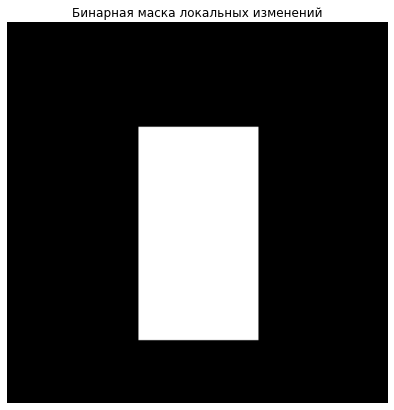

In [16]:
plt.figure(figsize=(7, 7))
plt.title("Бинарная маска локальных изменений")
plt.axis("off")
plt.imshow(mask_of_changes, cmap='gray')

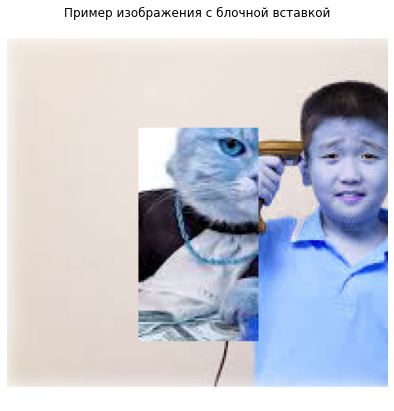

In [17]:
# Пример вставки одного изображения в другое
image_with_blocks_sample = \
  insert_image_block_to_another(
      images_array[0],
      images_array[1],
      mask_of_changes,
      )

plt.figure(figsize=(7, 7))
plt.title("Пример изображения c блочной вставкой")
plt.imshow(image_with_blocks_sample)
_ = plt.axis("off")

### Задание 2 

*Сгенерировать составные изображения из по-разному сжатых JPEG-изображений (одно произвольное сочетание $QF_{1.1}$, $QF_{1.2}$ и $QF_2$)*

In [18]:
def generate_splicing_images(
    images: np.ndarray,
    bin_mask_of_changes: np.ndarray,
    qf11: Union[int, List[int]],
    qf12: Union[int, List[int]],
    qf2: Union[int, List[int]],
) -> Optional[np.ndarray]:
  """Генерация составных изображений с разными JPEG-изображениями."""

  if len(images.shape) != 4:
    return None

  num_images, rows, cols, _ = images.shape

  if bin_mask_of_changes.shape[0] != rows \
    and bin_mask_of_changes.shape[1] != cols:
    return None

  splicing_image_list = []
  
  for i in tqdm(range(num_images)):
    current_image = images[i]
    another_image = images[i - 1]

    current_image_jpg = jpeg_compress(current_image, qf11)
    another_image_jpg = jpeg_compress(another_image, qf12)

    splicing_image = insert_image_block_to_another(
        current_image_jpg,
        another_image_jpg,
        bin_mask_of_changes,
    )

    splicing_image_jpg = jpeg_compress(splicing_image, qf2)

    splicing_image_list.append(splicing_image_jpg)

  return np.array(splicing_image_list)

In [19]:
splicing_images = generate_splicing_images(
    images_array,
    mask_of_changes,
    qf11=QF11,
    qf12=QF12,
    qf2=QF2,
  )

100%|██████████| 10/10 [00:00<00:00, 129.46it/s]


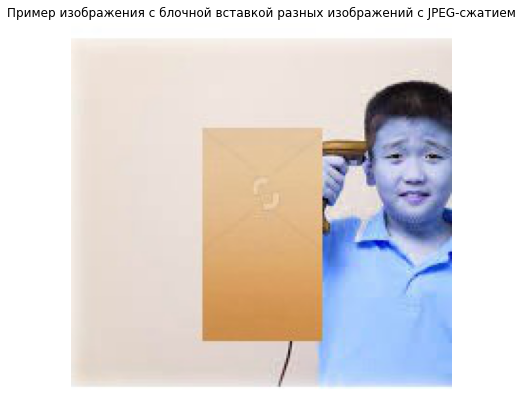

In [20]:
# Пример изображения
plt.figure(figsize=(7, 7))
plt.title("Пример изображения c блочной вставкой разных изображений с JPEG-сжатием")
plt.imshow(splicing_images[0])
_ = plt.axis("off")

### Задание 3 

*Автоматически сформировать маску изменений по одному произвольному ДКП-коэффициенту. При этом нельзя использовать информацию об истинных значениях $QF_{1.1}$, $QF_{1.2}$ и $QF_2$*

In [21]:
max_coeffs, _ = utils.max_min_coefficient(
    quality_range=(50, 100),
    n_coeffs=15,
    zig_zag_order=True,
)

model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects=({
        'custom_softmax': networks.custom_softmax_activation(max_coeffs),
        'custom_two_terms_loss_wrapper': networks.custom_two_terms_loss_wrapper(
            max_coeffs, 0.8),
        'custom_mse': networks.custom_mse_wrapper(max_coeffs)})
)

In [24]:
predicted_maps = []
predicted_labels = []

for i in tqdm(range(len(splicing_images))):
  splicing_image = splicing_images[i]
  img = preprocess_input(splicing_image)
  map, label = localization.window_decision(
      img,
      model, 
      max_coeffs, 
      (64, 64, 1), 
      stride=BASE_STRIDE,
  )
  predicted_maps.append(map)
  predicted_labels.append(label)

100%|██████████| 10/10 [07:23<00:00, 44.31s/it]


In [25]:
predicted_maps_array = np.array(predicted_maps)
predicted_label_array = np.array(predicted_labels)

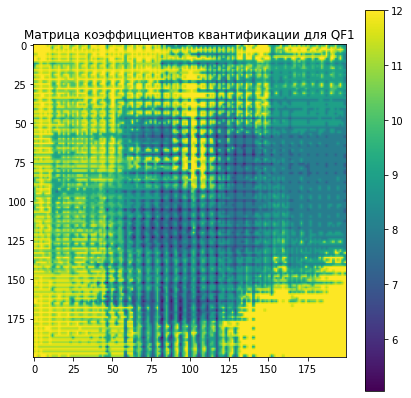

In [26]:
plt.figure(figsize=(7, 7))
plt.title("Матрица коэффицциентов квантификации для QF1")
plt.imshow(predicted_maps_array[0][:, :, 0])
plt.colorbar()

In [27]:
predicted_label_array[0, :, 0]

array([12., 12., 12., ..., 12., 12., 12.])

### Задание 4

*Выбрать меру оценивания качества построения маски изменений и произвести оценивание*

In [28]:
def map_segmentation(
    map: np.ndarray, 
    segment_number: int = 2,
) -> np.ndarray:
  """Сегментация маски."""
  flatten_map = map.flatten()
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  ret, label, center = cv2.kmeans(np.float32(flatten_map), segment_number, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
  return label.reshape(map.shape)

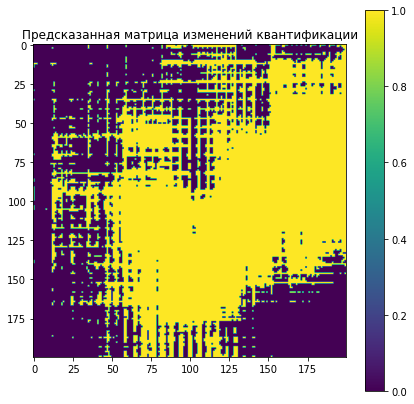

In [29]:
sample_segmentation_map = map_segmentation(predicted_maps_array[0][:, :, 0])
plt.figure(figsize=(7, 7))
plt.title("Предсказанная матрица изменений квантификации")
plt.imshow(sample_segmentation_map)
plt.colorbar()

In [30]:
print(f"""
RMSE = {rmse(mask_of_changes, sample_segmentation_map)}
Accuracy = {accuracy(mask_of_changes, sample_segmentation_map)}
""")


RMSE = 0.6423589339302443
Accuracy = 0.587375



In [31]:
def map_estimation(
    true_map: np.ndarray,
    predicted_map: np.ndarray,
) -> Tuple[float, float]:
  """Оценка предсказания для данной матрицы изменений."""
  segmented_map = map_segmentation(predicted_map)
  if segmented_map[0, 0] == 1:
    segmented_map[segmented_map == 1] = 2
    segmented_map[segmented_map == 0] = 1
    segmented_map[segmented_map == 2] = 0
  rmse_value = rmse(true_map, segmented_map)
  accuracy_value = accuracy(true_map, segmented_map)
  return rmse, accuracy_value

In [32]:
rmse_values = []
accuracy_values = []
for i in range(len(predicted_maps_array)):
  map_qf1 = predicted_maps_array[i][:, :, 0]
  rmse_value, accuracy_value = map_estimation(mask_of_changes, map_qf1)
  rmse_values.append(rmse_value)
  accuracy_values.append(accuracy_value)

In [41]:
print(f"Среднее Accuracy: {np.mean(accuracy_values)}")

Среднее Accuracy: 0.5229700000000002
